# Env setup

In [1]:
import sys
from google.colab import drive
drive.mount('/content/A_drive')
sys.path.append('/content/A_drive/MyDrive/MLIS_car/src')
!pip install wandb -qqq
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install "opencv-python-headless<4.3"
import wandb
import pickle
import time
import tensorflow as tf
from tensorflow import keras
from datahandle import *
import datahandle
import importlib
from keras.layers.merge import concatenate
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.numpy_ops import np_array_ops
from tensorflow.python.framework import constant_op


Mounted at /content/A_drive
     |████████████████████████████████| 1.8 MB 28.0 MB/s 
     |████████████████████████████████| 144 kB 72.7 MB/s 
     |████████████████████████████████| 181 kB 73.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cdjwnv2t
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cdjwnv2t
     |████████████████████████████████| 47.8 MB 1.9 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=97b6152a7d20a863040bb0a6a65b140bde8160dbacb81a9837486c8a3b0f7086
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2gqhtwm/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfu

# Hyperparam setup

In [2]:
#hyper
root = '/content/A_drive/MyDrive/MLIS_car'
task_augmentation_dir= root+'/data/task_specific_augmentation/'
directory = root +'/data/A_training_given/training_data/'
training_folder = 'training_data'
training_labels_file= 'training_norm.csv'
#
collected_directory = root +'/data/Z_collected_raw/' 
made_directory = root +'/data/X_made_raw/' 

#
quiz_directory = root +'/data/C_testing_given/test_data/'
quiz_training_folder = 'test_data'
#configurations
conf_tracking = 1

# Dataloader setup

## loader objects

In [3]:
#dataloading object
training_object= datahandle.DataLoader_test(
        directory,
        training_folder,
        training_labels_file,
        task_augmentation_dir=task_augmentation_dir
        )
collected_object = datahandle.DataLoader_test(
        collected_directory,        
        task_augmentation_dir=task_augmentation_dir
        )
made_object = datahandle.DataLoader_test(
        made_directory,        
        task_augmentation_dir=task_augmentation_dir)
        

## function to get data information (not images)

In [4]:
def get_data_info(batch_size=32, split=0.8):
  made_train, made_test = made_object.LoadCollectedData_info(
          split=split,
          batch_size=batch_size) #for tf this batch size remains as 1
          
  collected_train, collected_test = collected_object.LoadCollectedData_info(
          split=split,
          batch_size=batch_size #for tf this batch size remains as 1
          )
  #train test split
  train,test = training_object.LoadModelData_info(
          split = split, 
          batch_size =batch_size)#for tf this batch size remains as 1
  return train,collected_train,test[0],collected_test[0],made_train,made_test[0]
a,b,c,d,e,f = get_data_info(batch_size=32, split=0.8)
example_batch = training_object.Load_batch(a[0], data_shape='original')

(344, 32, 4) (21, 32, 4) (2757, 4) (174, 4) (45, 32, 4) (360, 4)
(240, 320, 3)


dtype('uint8')

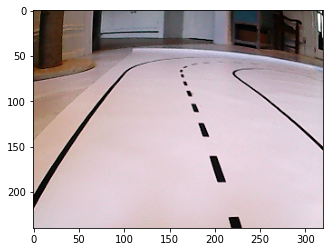

In [5]:
print(a.shape,b.shape,c.shape,d.shape,e.shape,f.shape)
print(example_batch[0][0].shape)
plt.imshow(example_batch[0][0])
example_batch[0][0].dtype

# Model setup

### Function to get Pretrained model

In [6]:
def GetBaseModel(image_shape,name='transfermodel'):
  Base = tf.keras.applications.MobileNetV3Small(
      input_shape=image_shape,
      include_top=False,weights='imagenet',
      pooling='avg'
  )
  Base.trainable = False
  Base._name = name
  return Base

### Function to build model

In [7]:
def BuildInitialModel(angle_base,speed_base, image_shape, lr):
  inference_layer_angle = tf.keras.layers.Dense(1, activation='relu', name='angle_inference')
  inference_layer_speed = tf.keras.layers.Dense(1, activation='relu', name='speed_inference')

  resize = tf.keras.layers.Resizing(
    224,
    224,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)
  inputs = tf.keras.layers.Input(shape=image_shape)

  x = resize(inputs)
  y = angle_base(x)
  z = speed_base(x)
  angle_output = inference_layer_angle(y)
  angle_output._name='angle_inference'
  speed_output = inference_layer_speed(z)
  speed_output._name='speed_inference'
  outputs = tf.keras.layers.Concatenate(axis=1)([angle_output, speed_output])
  model = tf.keras.Model(inputs, outputs)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
  return model

In [8]:
base_angle = GetBaseModel((224,224,3),name='mobilenet_1')
base_speed = GetBaseModel((224,224,3),name='mobilenet_2')
model = BuildInitialModel(base_angle,base_speed,(240,320,3),0.001)

4349952/4334752 [==============================] - 0s 0us/step


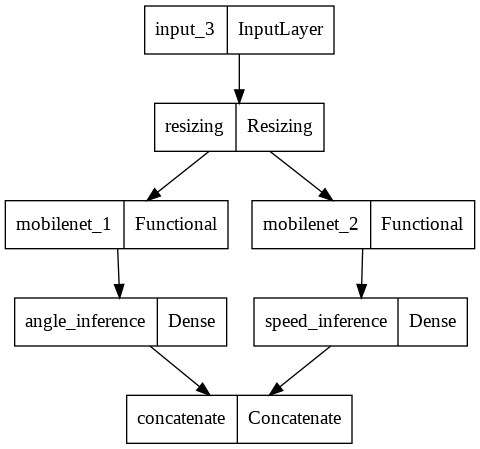

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
angle_base = model.get_layer('mobilenet_1')
speed_base = model.get_layer('mobilenet_2')
angle_base.summary()

Model: "mobilenet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                        

### Function to make the pretrained model trainable

In [11]:
def MakeModelTunable(model,Base, tune_from, lr):
  Base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = tune_from
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in Base.layers[:fine_tune_at]:
    layer.trainable = False
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
  return model, Base

# Tracking

In [12]:
#wandb tracking
if conf_tracking:
    config = {
     "model_type" : 'Transfer Learning with mobilenet competition',
    }
    run = wandb.init(project="Autonomous-driving", entity="mo379",config=config)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# protocol programmable training loop

In [13]:
def protocol_training(model, protocol):
  for i,pro in enumerate(protocol):
    print(f'--- protocol step {i} using -> {pro}')
    ##Getting protocole variables
    tuning_starting_layer_angle = pro['fine_tuning_start_angle']
    tuning_starting_layer_speed = pro['fine_tuning_start_speed']
    n_epochs = pro['n_epochs']
    batch_size = pro['batch_size']
    split = pro['split']
    data_shape = pro['data_shape']
    learning_rate = pro['learning_rate']
    data_norm= pro['data_norm']
    data_col= pro['data_col']
    data_gen= pro['data_gen']
    augmentation_protocol = pro['augmentation_protocol']
    ###Setup up
    #setup the model either for fine tuning or from scratch
    ###
    if tuning_starting_layer_angle:
      angle_base = model.get_layer('mobilenet_1')
      speed_base = model.get_layer('mobilenet_2')
      model,angle_base = MakeModelTunable(model,angle_base, tuning_starting_layer_angle,learning_rate)
      model,speed_base = MakeModelTunable(model,speed_base, 250,learning_rate)
      model.get_layer('angle_inference').trainable=True
      model.get_layer('speed_inference').trainable=False
    elif tuning_starting_layer_speed:
      angle_base = model.get_layer('mobilenet_1')
      speed_base = model.get_layer('mobilenet_2')
      model,angle_base = MakeModelTunable(model,angle_base, 250,learning_rate)
      model,speed_base = MakeModelTunable(model,speed_base, tuning_starting_layer_speed,learning_rate)
      model.get_layer('angle_inference').trainable=False
      model.get_layer('speed_inference').trainable=True
    else:
      angle_base = model.get_layer('mobilenet_1')
      speed_base = model.get_layer('mobilenet_2')
      model,angle_base = MakeModelTunable(model,angle_base, 250,learning_rate)
      model,speed_base = MakeModelTunable(model,speed_base, 250,learning_rate)
    
    model.summary() 

    #get the data
    train,train_collected,test,test_collected,train_gen,test_gen =  get_data_info(batch_size=batch_size,split=split)
    to_stack = [train,train_collected,train_gen]
    to_stack_test = [test,test_collected,test_gen]
    to_remove = []
    if data_norm ==0:
      to_remove.append(0)
    if data_col==0:
      to_remove.append(1)
    if data_gen ==0:
      to_remove.append(2)
    for index in sorted(to_remove, reverse=True):
      del to_stack[index] 
      del to_stack_test[index] 
    train_XY = np.vstack(to_stack) 
    
    if split < 1:
      test_XY = np.vstack(to_stack_test)
      rounded =  round(len(test_XY)/4)*4-4
      print(test_XY.shape, rounded)
      test_batches = test_XY[0:rounded].reshape(4,-1,4)
    # setup augmentation
    if augmentation_protocol:
      aug_status = True
      aug_protocol = augmentation_protocol
      aug_size = 256
    else:
      aug_status=False
      aug_protocol=[]
      aug_size = 256

    np.random.shuffle(train_XY)
    ### start ith protocol training
    for epoch in range(n_epochs):
        print(f'--- epoch {epoch}')
        for i in range(len(train_XY)):
            X,Y = training_object.Load_batch(train_XY[i], data_shape=data_shape, 
                                             augmentation=aug_status, augmentation_pass=1
                                             ,augmentation_protocol=aug_protocol,
                                             augmentation_size= aug_size)
            train_metrics = model.train_on_batch(X,Y, return_dict=True) 
            if i % 5 == 0:
                if split < 1:
                  X_test,Y_test = training_object.Load_batch(test_batches[np.random.randint(0,3)], data_shape=data_shape)
                  test_metrics = model.test_on_batch(
                      X_test, Y_test, sample_weight=None, reset_metrics=False, return_dict=True
                  )
                  test_loss = test_metrics['loss']
                batch_loss = train_metrics['loss']
                
                if conf_tracking==1:
                  wandb.log({"batch_loss": batch_loss})
                  if split < 1:
                    wandb.log({"test_loss": test_loss})
                    print(f'--- batch {train_metrics}, test {test_metrics}')
                  else:
                    print(f'--- batch_loss {batch_loss}')
                else:
                  print(f'--- batch {train_metrics}, test {test_metrics}')

  return model

In [14]:
#_path = root+'/pkls/twomodel_SparkMcQueen_01.pkl'
#model = keras.models.load_model(_path)
#base = model.layers[1]


base_angle = GetBaseModel((224,224,3),name='mobilenet_1')
base_speed = GetBaseModel((224,224,3),name='mobilenet_2')
model = BuildInitialModel(base_angle,base_speed,(240,320,3),0.001)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 mobilenet_1 (Functional)       (None, 576)          939120      ['resizing_1[0][0]']             
                                                                                                  
 mobilenet_2 (Functional)       (None, 576)          939120      ['resizing_1[0][0]']       

In [16]:
protocol = [
    {
        'fine_tuning_start_angle':0,'fine_tuning_start_speed':250, 
        'n_epochs':5, 'batch_size': 128,'split':0.8,
        'data_shape':'original','learning_rate':0.001, 
        'data_norm':1,'data_col':0,'data_gen':0,
        'augmentation_protocol':
          [
            'Normal',
            'TurnBias',
            'StopGoLights',
            'StopForObjec',
            'SyntheticStopGoLights',
          ]
     },
    {
        'fine_tuning_start_angle':250,'fine_tuning_start_speed':0, 
        'n_epochs':5, 'batch_size': 128,'split':0.8,
        'data_shape':'original','learning_rate':0.0001, 
        'data_norm':1,'data_col':0,'data_gen':0,
        'augmentation_protocol':
          [
            'Normal',
            'TurnBias',
            'StopGoLights',
            'StopForObjec',
            'SyntheticStopGoLights',
          ]
     },
 
]      
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       
       

# model run


In [17]:
model= protocol_training(model,protocol)

--- protocol step 0 using -> {'fine_tuning_start_angle': 0, 'fine_tuning_start_speed': 250, 'n_epochs': 5, 'batch_size': 128, 'split': 0.8, 'data_shape': 'original', 'learning_rate': 0.001, 'data_norm': 1, 'data_col': 0, 'data_gen': 0, 'augmentation_protocol': ['Normal', 'TurnBias', 'StopGoLights', 'StopForObjec', 'SyntheticStopGoLights']}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                               

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [ ]:
model_path = root+'/pkls/two_model_SparkMcQueen_1.pkl'
#model = tf.keras.models.load_model(model_path, custom_objects=None, compile=True, options=None)

tf.keras.models.save_model(
    model,
    model_path,
    overwrite=False,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

In [18]:
run.finish()

batch_loss,█▇▅▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
test_loss,▇█▇▇▇▆▆▅▄▄▄▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
batch_loss,0.05924
test_loss,0.15936


# Loading the Quiz data

In [ ]:
quiz_object= DataLoader_test(
    quiz_directory,
    quiz_training_folder,
)
data_shape = 'original'
quiz_train = quiz_object.LoadQuizData_info()
X,image_order = quiz_object.Load_batch_quiz(quiz_train,data_shape=data_shape)

# Making predictions

In [ ]:
prds = model.predict(X)
final_prd = np.column_stack((image_order,prds))
final_ordered = final_prd[final_prd[:, 0].argsort()]
df = pd.DataFrame(final_ordered, columns = ['image_id','angle','speed'])
df = df.astype({'image_id': 'int32'})
df.to_csv(root+'/predictions/SparkMcqueen.csv', index=False,)

In [ ]:
df

In [ ]:
_path = root+'/pkls/two_model_SparkMcQueen_1.pkl'

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(root+'/pkls/two_model_SparkMcQueen_01.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
tflite_model.summary()

In [ ]:
model.summary()